In [26]:
from sklearn.metrics import pairwise_distances_argmin, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from data import *
from sklearn.preprocessing import StandardScaler
from kmeans import *
from pca import *

In [27]:
def calculate_WSS(points, kmax):
    sse = []
    for k in range(1, kmax + 1):
        kmeans = KMeans(n_clusters=k).fit(points)
        centroids = kmeans.cluster_centers_
        pred_clusters = kmeans.predict(points)
        curr_sse = 0

        # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

        sse.append(curr_sse)

    return sse

In [28]:
def elbow_graphs(data, dimension):
    x_vals = []
    for i in range(1, 101):
        x_vals.append(i)
    res = calculate_WSS(data, 100)
    plt.plot(x_vals, res)
    plt.xlabel("K")
    plt.ylabel("WSS")
    title = "Elbow method results on symptoms search popularity in " + dimension + " dimensions"
    plt.suptitle(title)
    plt.show()


/Users/admin/COMP551/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


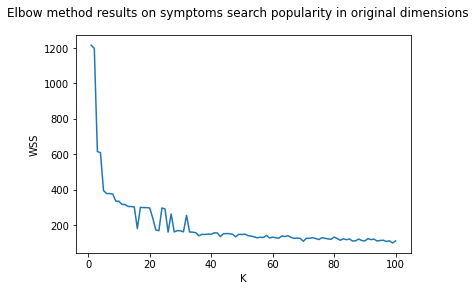

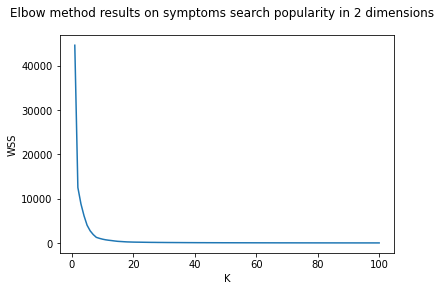

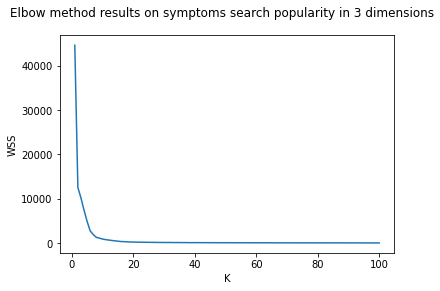

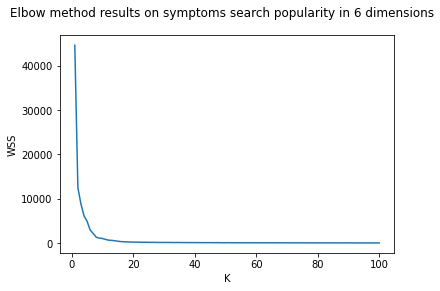

In [29]:
dataset = Data()
dataset.filter_out_zeros()
dataset.fill_na(0)
symptoms = dataset.d.columns[8:-1]
symptom_data = dataset.d.loc[:,symptoms].values
symptom_data = StandardScaler().fit_transform(symptom_data)

elbow_graphs(symptom_data, "original")

pca_data = PCAPlotting(dataset.d)
reduced_2d = pca_data.reduce_dimensionality(2)
elbow_graphs(reduced_2d, "2")

reduced_3d = pca_data.reduce_dimensionality(3)
elbow_graphs(reduced_3d, "3")

reduced_6d = pca_data.reduce_dimensionality(6)
elbow_graphs(reduced_6d, "6")

In [31]:
def intersect(a, b):
    """ return the intersection of two lists """
    return list(set(a) & set(b))

def consistency(num_clust, labels_high_dim, labels_low_dim):

        list1 = []
        list2 = []
        for i in range(num_clust):
            list1.append([])
            list2.append([])
        for i in range(len(labels_high_dim)):
            list1[labels_high_dim[i]].append(i)

        for i in range(len(labels_low_dim)):
            list2[labels_low_dim[i]].append(i)

        intersec = []

        for j in range(len(list1)):
            for k in range(len(list2)):
                intersec.append((len(intersect(list1[j], list2[k])), (j, k)))
        percentage_intersec = []
        for i in range(num_clust):
            if len(intersec) != 0:
                maximum = max(intersec)
                coord = maximum[1]
                mean_lists_length = (len(list1[coord[0]]) + len(list2[coord[1]])) / 2
                percentage_intersec.append((maximum[0] / mean_lists_length) * 100)
                intersec.remove(max(intersec))
        return (percentage_intersec, sum(percentage_intersec) / len(percentage_intersec))

Methodology for consistency:

    1) Get cluster "labels" or "appartenance" for each data point in high dimensions
       and low dimensions. Note that the number of clusters used in original dims and lower
       dims should be the same
    2) Divide the points into sublists based on their labels. We get two 2D lists with
       n sublists each, where n = number of clusters chosen. Call the two lists X and Y
    3) Find all the intersections Lij representing intersection of sublist Xi with sublist
       Yj for i,j = 1,2,...,n. We should be getting n x n intersections. This step is done since
       we are not guaranteed that label x in high dimensions correspond to the same label in lower dimension
    4) Pick the n largest intersection lengths from the n x n ones obtained by keeping track of Xi and Yj which
       were the sublists "intersected". We assume that Xi and Yj would be considered the "same" clusters since
       they have the largest intersection compared to the rest of the n x n intersection lengths
    5) We then have Lij = intersection of Xi (cluster i in high dims) and Yj (cluster Xi but in low dim) where Xi and Yj
       are considered the "same clusters" for the reason mentionned in 4)
    6) Compute Cij = (|Lij| / ((|Xi| + |Yj|)/2)) (where |x| is the cardinality of x), ie we are
       trying to find what proportion of the total number of datapoints in clusters Xi and Yj, the intersection represents.
       This gives the consistency percentage from Xi (original dims) to Yj (lower dims), ie how many points fall in the same
       cluster together again in lower dimensions
    7) This is repeated for all n largest intersections and their mean X is calculated. Therefore X represents the average
       number of points that fall together again in the same cluster when reduced to the lower dimension and hence gives
       an idea of how faithful is the clustering when visualized in lower dimensions

In [32]:
def get_consistency(dimension, num_clusters):
    dataset = Data()
    dataset.filter_out_zeros()
    dataset.fill_na(0)
    symptoms = dataset.d.columns[8:-1]
    symptom_data = dataset.d.loc[:,symptoms].values
    symptom_data = StandardScaler().fit_transform(symptom_data)

    kmeans_original = Kmeans(symptom_data)
    labels_original_dim = kmeans_original.find_clusters(num_clusters)

    pca_data = PCAPlotting(dataset.d)
    reduced_xd = pca_data.reduce_dimensionality(dimension)
    kmeans_xd = Kmeans(reduced_xd)
    labels_x_dim = kmeans_xd.find_clusters(num_clusters)

    consistency_xd = consistency(num_clusters, labels_original_dim, labels_x_dim)
    print("{ Percentage of points falling in the same cluster together again = ",
          consistency_xd[1], "\nwith dimensions reduced to ", dimension, " and number of clusters = ",
          num_clusters, " }\n\n")

In [35]:
get_consistency(2, 15)
get_consistency(3, 15)
#Optimal number of PCs
get_consistency(6, 15)




<ipython-input-35-4c2ca46b6d10>:1: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  get_consistency(2, 15)
<ipython-input-35-4c2ca46b6d10>:2: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  get_consistency(3, 15)
<ipython-input-35-4c2ca46b6d10>:4: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  get_consistency(6, 15)


{ Percentage of points falling in the same cluster together again =  87.94508212349793 
with dimensions reduced to  2  and number of clusters =  15  }


{ Percentage of points falling in the same cluster together again =  81.57029460762202 
with dimensions reduced to  3  and number of clusters =  15  }


{ Percentage of points falling in the same cluster together again =  98.12032192044843 
with dimensions reduced to  6  and number of clusters =  15  }


